# Feed Forward Neural Network Demo in Pytorch


Implementation of a simple FFNN in PyTorch for hand-drawn digits classification trained on the MNIST dataset. Our objective is to build and train a simple neural network that given an image of a handwritten digit, correctly classify it as a number from 0 to 9.

Comments for the explanation of most code are given. Please go through them and also explore the new libraries and methods used here.

PS: This notebook is meant for pedagogical purposes and is by no means the most efficient implementation for the network


## Importing required Libraries

All the required libraries and their purpose is mentioned

In [1]:
import torch
import torch.nn as nn   #Contains neural network layers, loss functions etc
import torchvision      #Contains datasets, models and image transformations. We use it to download our dataset
import torchvision.transforms as transforms               #used for pre-processing images
from torch.utils.data import DataLoader                   #Dataloader helps with batching
from torch.utils.data import random_split                 #For splitting the data
import numpy as np
import matplotlib.pyplot as plt                           #For plotting


#Set seeds for reproducibility
torch.manual_seed(1)
np.random.seed(1)

### Hyperparameters

We define the hyperparameters beforehand so that its easier to tune them later

In [2]:
# hyperparameters
input_size = 784
hidden_size_1 = 128
hidden_size_2 = 64
num_classes = 10  #output layer
learning_rate = 0.001
batch_size = 128
num_epochs = 15

## Loading Raw Data

We will be training our NN on MNIST dataset for classification. MNIST dataset contains grayscale images of handwritten digits(0-9) of size 28*28.

The MNIST database contains 60,000 training images and 10,000 testing images. It’s the "Hello, World!" of image classification to compare basic models due to its small size and simplicity.


For more information you can go through:

https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html

https://en.wikipedia.org/wiki/MNIST_database#

### First let's take a look at raw data and see what type of pre-processing might be required for our data

In [3]:
raw_train_dataset = torchvision.datasets.MNIST(root='./data',           #directory to store dataset
                                           train=True,              #training set
                                           download=True,           #Downaload the dataset if not available in the directory
                                           transform=None      #apply the pre-defined transformation to each image
                                           )
#test dataset
raw_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [4]:
X_train_raw = raw_train_dataset.data        #X values are stored in data
y_train_raw = raw_train_dataset.targets     #y values are stored in targets

digits, counts = np.unique(y_train_raw, return_counts=True)
for i, j in zip(digits, counts):
    print(f'Digit: {i}, Count: {j}')


Digit: 0, Count: 5923
Digit: 1, Count: 6742
Digit: 2, Count: 5958
Digit: 3, Count: 6131
Digit: 4, Count: 5842
Digit: 5, Count: 5421
Digit: 6, Count: 5918
Digit: 7, Count: 6265
Digit: 8, Count: 5851
Digit: 9, Count: 5949


In [5]:
print(f'Training dataset details:\n X : {X_train_raw.shape}, y : {y_train_raw.shape}')
print(f'Test dataset details:\n X : {raw_test_dataset.data.shape}, y : {y_train_raw.shape}')
print()
print(f'Shape of a sample from training set:\n {X_train_raw[0].shape}\n')
print(f'Sample from training set:\n {X_train_raw[0]}')
print()
print(f'Min Pixel Value: {X_train_raw.min()}, Max Pixel Value: {X_train_raw.max()}')

Training dataset details:
 X : torch.Size([60000, 28, 28]), y : torch.Size([60000])
Test dataset details:
 X : torch.Size([10000, 28, 28]), y : torch.Size([60000])

Shape of a sample from training set:
 torch.Size([28, 28])

Sample from training set:
 tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,

## Pre-Processing

We need to pre-process our data to make training feasible and efficient.
First thing we need to do is convert our data to tensor format and normalize it.

We saw that our data has pixel values ranging from (0,255). We need to scale and normalize it to the range (0,1). This helps with numerical stability and prevents dominance due to different scales and thus leading to improved model performance

Luckily, torchvision provides a module named transforms which can help us to pre-process our data while downloading it.


*   torchvision.transform.ToTensor() : Convert a PIL Image or numpy.ndarray to tensor while changing it to (0,1) range
*   torchvision.transform.Normalize() : Normalize a tensor image with mean and standard deviation


For details please see the documentation for torchvision.transforms:
https://docs.pytorch.org/vision/0.9/transforms.html#

In [6]:
#transformation pipeline to be applied to each image
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),          #Original PIL images are converted to tensor
    torchvision.transforms.Normalize(           #Normalize tensors using pre-computed mean and standard deviation of MNIST dataset
        (0.1307,), (0.3081,)
    )
])


train_dataset = torchvision.datasets.MNIST(root='./data',           #directory to store dataset
                                           train=True,              #training set
                                           download=True,           #Downaload the dataset if not available in the directory
                                           transform=transform      #apply the pre-defined transformation to each image
                                           )
#test dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

one way of getting mean and standard deviation for the dataset is as follows:


```
 loader = DataLoader(raw_train_dataset, batch_size=len(raw_train_dataset))
 data = next(iter(loader))[0]
 print(f"Mean: {data.mean()}, Std: {data.std()}")
```



## Visualizing the dataset

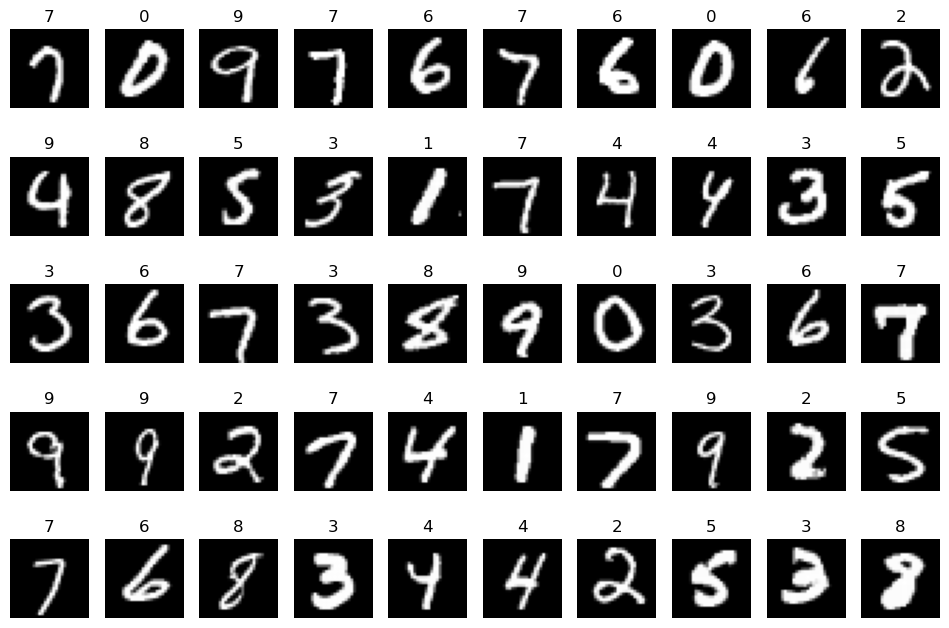

In [7]:
figure = plt.figure(figsize=(12, 8))
cols, rows = 10, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()    #random sample
    img, label = train_dataset[sample_idx]                              #input and labels are present as a tuple and we can access them like this
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Splitting Data

When a model is trained over a large number of epochs, it can end up memorizing the training dataset and does not perform well on unseen test data. This is called **overfitting**.

There are many ways in which overfitting can be prevented, one of which is to have a validation dataset. Validation set helps detect overfitting by evaluating the model performance on data it hasn't seen during training.

Validation is also useful to fine-tune different hyperparameters and configuration for a model. It can give an idea about generalization capabilities of a model

In [8]:
total_train_size = len(train_dataset)

train_size = int(0.8 * total_train_size)       #right now we are doing 80:20 split for train and validation. This can be changed
val_size = total_train_size - train_size

print(f'Total train size was: {total_train_size}')
print(f'New Train size is: {train_size}, Validation size is: {val_size}')

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

Total train size was: 60000
New Train size is: 48000, Validation size is: 12000


## DataLoader

DataLoader is a utility that helps efficiently load and batch data from a dataset, while providing features like Batching, shuffling. loading data in parallel and custom data loading logics.

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting. All this can be handled by pytorch DataLoader

Read more: https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #shuffled
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Iterating through a dataloader

Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


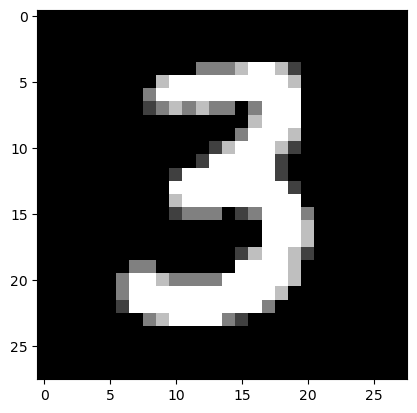

Label: 3


In [10]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
# print(f"Single sample shape: {train_features[0].shape}")
# print(f"Squeezing: {train_features[0].squeeze().shape}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [11]:
#Data iteration that happens during the training loop
for batch in train_dataloader:
    inputs, labels = batch  #returns batches as tuples
    print(inputs)
    print(labels)
    break

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Building the Neural Network

We define our neural network as a class that inherits from torch.nn.Module. **nn.Module** is the base class for all neural network modules in PyTorch.  It provides a lot of useful functionality, like tracking the model's parameters (weights and biases).


A basic NN class has two main parts:

__init__(): This is where we define the layers of our network. We'll use nn.Linear for our fully connected layers and nn.ReLU for our activation functions.

forward(): This method defines the forward pass of our network. It specifies how the input data flows through the layers we defined in __init__(). PyTorch automatically handles the backward pass (backpropagation) for us.

In [12]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()                         #IMPORTANT to Flatten the image; Details below
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(hidden_size_2, num_classes)

    def forward(self, x):
        #Here we explain the flow of our inputs through different model layers
        x = self.flatten(x)
        out = self.fc1(x)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        out = self.output(out)
        return out


### Flattening the image

We saw above that our image is a 2d array of size 28 by 28 but FFNN takes a linear 1d input. So, before we can use our image for training, we need to convert our 2d array to 1d (which would be 784(28*28)) which is also known as flattening.
Torch.nn.flatten can automatically flatten the image

You can see the the visualization for this process in the following video.

Video Credit: [3Blue1Brown](https://www.3blue1brown.com/lessons/neural-networks)

In [13]:
from IPython.display import HTML

video_url = 'https://www.google.com/url?q=https%3A%2F%2F3b1b-posts.us-east-1.linodeobjects.com%2Fcontent%2Flessons%2F2017%2Fneural-networks%2Fpixels-to-neurons.mp4%23t%3D0.001'
HTML(f"""
<video width=1000 controls>
<source src="{video_url}" type="video/mp4">
</video>
""")


### Activation Function

We use the Rectified Linear Unit (ReLU) as our activation function. An activation function's purpose is to introduce non-linearity into the model, allowing it to learn more complex patterns in the data. The ReLU function is a popular choice because it is computationally efficient and helps to mitigate the vanishing gradient problem.
Image [source](https://www.geeksforgeeks.org/deep-learning/relu-activation-function-in-deep-learning/)
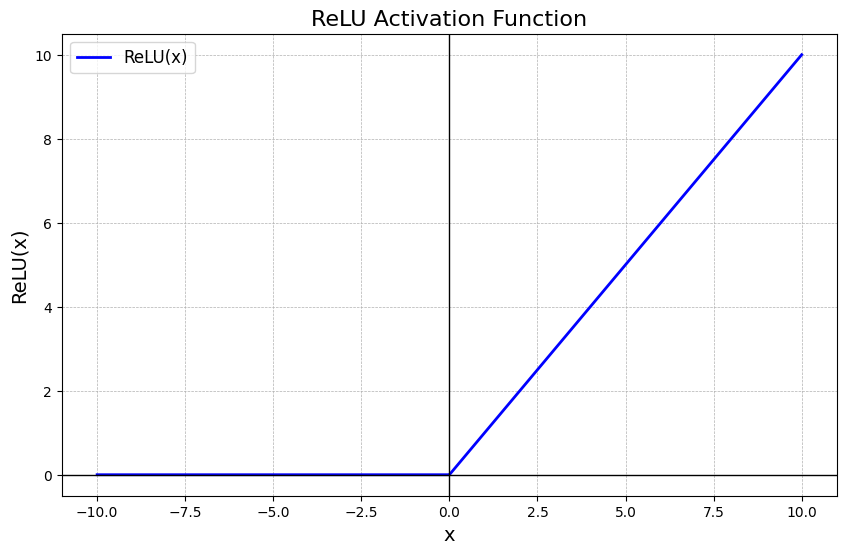

In [14]:
def predict_labels(x):
    p = torch.argmax(x, dim=1)
    return p

Behind the scene of how logits are converted to probabilities. Logits are the raw, unnormalized outputs of the last layer. The loss that we will be using automatically converts logits to softmax probabilities so we don't need to use softmax layer in our neural network

In [15]:
logits = [[1, 8, 2, 9, 0.365, 5, 12, 0.152, 0.6457, 0.12], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
logits = torch.tensor(logits)
print(logits)

soft = nn.Softmax(dim=1)
prob = soft(logits)
print(prob)
print(f'Sum of all elements after softmax for 1st sample: {prob[0].sum()}')
print(f'Sum of all elements after softmax for 2nd sample: {prob[0].sum()}')

print(predict_labels(prob))

tensor([[ 1.0000,  8.0000,  2.0000,  9.0000,  0.3650,  5.0000, 12.0000,  0.1520,
          0.6457,  0.1200],
        [ 0.0000,  1.0000,  2.0000,  3.0000,  4.0000,  5.0000,  6.0000,  7.0000,
          8.0000,  9.0000]])
tensor([[1.5622e-05, 1.7132e-02, 4.2465e-05, 4.6569e-02, 8.2787e-06, 8.5293e-04,
         9.3536e-01, 6.6905e-06, 1.0961e-05, 6.4798e-06],
        [7.8013e-05, 2.1206e-04, 5.7645e-04, 1.5669e-03, 4.2594e-03, 1.1578e-02,
         3.1473e-02, 8.5552e-02, 2.3255e-01, 6.3215e-01]])
Sum of all elements after softmax for 1st sample: 1.0
Sum of all elements after softmax for 2nd sample: 1.0
tensor([6, 9])


## Training Loop

Following is the training loop for our Neural network. The arguments include model, training and validation data, batch size, learning rate, patience, max epochs and verbose.

Patience is another way of preventing overfitting. When the validation loss does not improve for a given successive number of count, the training is stopped. This is also known as EarlyStopping.

**Overview of training loop:**
Device is defined first and model is loaded into it. Next, loss function and optimizer are defined and for each epoch of training data a forward and backward pass is implemented and loss and accuracy are calculated. Similarily for validation set forward pass is done and the metrics are calculated. Criteria for EarlyStopping is checked and if model does not improve, training is stopped. Finally, accuracy and loss for both training and validation set is plotted with respect to epochs

In [16]:
def train(model, train_loader, val_loader, lr=1e-2, patience=5, max_epochs=10, verbose=True):
    device = "cuda" if torch.cuda.is_available() else "cpu"     #Use GPU whenever possible
    print(f'Started training on {device}')

    model = model.to(device)                                    #moving model to available device


    #Loss fn and optimizer
    criterion = nn.CrossEntropyLoss()       # Loss used for multi-class classification. measures difference between predicted probabilities and the actual labels. Softmax included
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    total_train_loss = []
    total_val_loss = []
    total_train_acc = []
    total_val_acc = []

    counter = 0
    best_val_loss = np.inf

    #main training loop
    for epoch in range(max_epochs):

        model.train()           #set model to training mode. Dropouts, BatchNorm are active (will be discussed later)
        running_loss = 0.0
        correct = 0
        total = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)   #Move data to the same device as model

            outputs = model(x)

            loss_t = criterion(outputs, y)      #loss calculation

            #Backprop
            optimizer.zero_grad()   #PyTorch accumulates gradients, so we need to clear them out before each backward pass
            loss_t.backward()       #Compute gradients of loss with respect to model's parameters
            optimizer.step()        #UpdAte model parameters using the gradients, lr etc

            #loss accumulation and accuracy calculation
            running_loss += loss_t.item() * x.size(0)
            pred = predict_labels(outputs)
            correct += (pred == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / total  #save loss and accuracy
        train_acc = correct / total

        model.eval()        #set model to eval mode. Dropouts, BatchNorm are not active
        val_running_loss, val_correct, val_total = 0.0, 0, 0

        # For validation set we dont want are model weights to be updated. So we disable gradient calculation so that model does not learn from this data.
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)       #move data to same device as model

                outputs = model(x)

                loss_v = criterion(outputs, y)

                val_running_loss += loss_v.item() * x.size(0)
                pred = predict_labels(outputs)
                val_correct += (pred == y).sum().item()
                val_total += y.size(0)

            val_loss = val_running_loss / val_total
            val_acc = val_correct / val_total

            total_train_loss.append(train_loss)
            total_val_loss.append(val_loss)
            total_train_acc.append(train_acc)
            total_val_acc.append(val_acc)

            if verbose:
                print(f'Epoch: {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

            #EarlyStopping criteria
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break



    if verbose:
        epochs = np.arange(1, len(total_train_loss)+1)
        plt.figure(figsize=(6,4))

        # Plotting train and val loss
        plt.plot(epochs, total_train_loss, label='Train Loss')
        plt.plot(epochs, total_val_loss, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-Entropy Loss')
        plt.title('Loss history')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plotting train and val accuracy
        plt.figure(figsize=(6,4))
        plt.plot(epochs, total_train_acc, label='Train Accuracy')
        plt.plot(epochs, total_val_acc, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy history')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return total_train_loss, total_val_loss, total_train_acc, total_val_acc

### Instantiating the Model

We use our previously defined hyperparameters and Neuralnetwork class **SimpleNN**, to define our model.

Choosing no of layers and neurons per layer is not a trivial task. Too few, and it might underfit. Too many, and it might overfit more easily and take longer to train. So this is a trade-off you have to choose based on your circumstances

In [17]:
model = SimpleNN(input_size, hidden_size_1, hidden_size_2, num_classes)
print(model)

SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
)


### Model Training

Started training on cpu
Epoch: 1/15, Train Loss: 0.3548, Val Loss: 0.1852, Train Acc: 0.8987, Val Acc: 0.9463
Epoch: 2/15, Train Loss: 0.1489, Val Loss: 0.1306, Train Acc: 0.9555, Val Acc: 0.9617
Epoch: 3/15, Train Loss: 0.1036, Val Loss: 0.1178, Train Acc: 0.9689, Val Acc: 0.9640
Epoch: 4/15, Train Loss: 0.0781, Val Loss: 0.1014, Train Acc: 0.9766, Val Acc: 0.9699
Epoch: 5/15, Train Loss: 0.0588, Val Loss: 0.0944, Train Acc: 0.9821, Val Acc: 0.9715
Epoch: 6/15, Train Loss: 0.0470, Val Loss: 0.1036, Train Acc: 0.9853, Val Acc: 0.9700
Epoch: 7/15, Train Loss: 0.0399, Val Loss: 0.0932, Train Acc: 0.9869, Val Acc: 0.9742
Epoch: 8/15, Train Loss: 0.0306, Val Loss: 0.0898, Train Acc: 0.9906, Val Acc: 0.9744
Epoch: 9/15, Train Loss: 0.0252, Val Loss: 0.0935, Train Acc: 0.9920, Val Acc: 0.9759
Epoch: 10/15, Train Loss: 0.0221, Val Loss: 0.0947, Train Acc: 0.9927, Val Acc: 0.9768
Epoch: 11/15, Train Loss: 0.0215, Val Loss: 0.1021, Train Acc: 0.9925, Val Acc: 0.9745
Epoch: 12/15, Train Loss: 0.

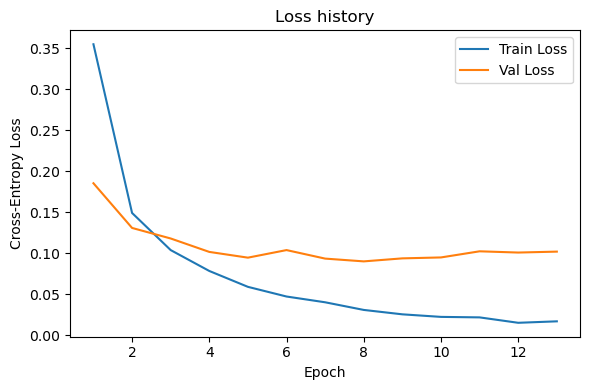

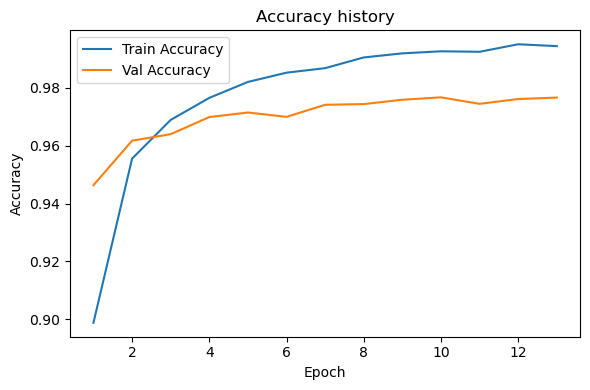

In [18]:
losses = train(model, train_dataloader, val_dataloader, lr=learning_rate, patience=5, max_epochs=num_epochs)

Let's check the predictions of our model on a single batch

In [19]:
#Checking predictions
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)   #move model to specified device

# Get the first batch from the test_dataloader
test_features, test_labels = next(iter(test_dataloader))

print(f'First batch labels:\n {test_labels}')   #true labels
with torch.no_grad():
    # Move the features to the device and get predictions
    first_batch_preds = model(test_features.to(device))
print(f'First batch predictions:\n {predict_labels(first_batch_preds)}')

First batch labels:
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5])
First batch predictions:
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 9, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5])


### Accuracy calculation on Complete Test Set

In [20]:
#accuracy
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

correct = 0
total = 0
#save these for later analyses
all_predicted = []
all_labels = []

with torch.no_grad():
    for data, labels in test_dataloader:
        data, labels = data.to(device), labels.to(device)   #move data to device
        outputs = model(data)
        predicted = predict_labels(outputs)

        all_predicted.append(predicted)
        all_labels.append(labels)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

full_test_acc = correct / total
print(f'Test accuracy: {full_test_acc*100}%')

# Concatenate all predicted and label tensors
all_predicted = torch.cat(all_predicted)
all_labels = torch.cat(all_labels)

Test accuracy: 97.53%


we also use different metrics like recall, precision and f1-score to get a better picture

### Confusion Matrix

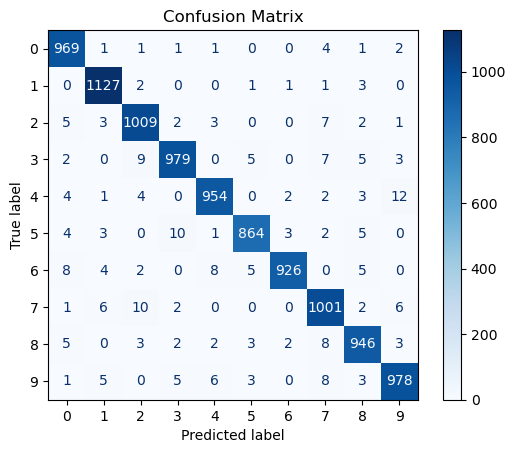

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# The predictions are on the GPU, so we need to move them to the CPU for sklearn
cm = confusion_matrix( all_labels.cpu(), all_predicted.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Number of incorrect predictions on the test set: 247
This is an error rate of 2.4699999999999998



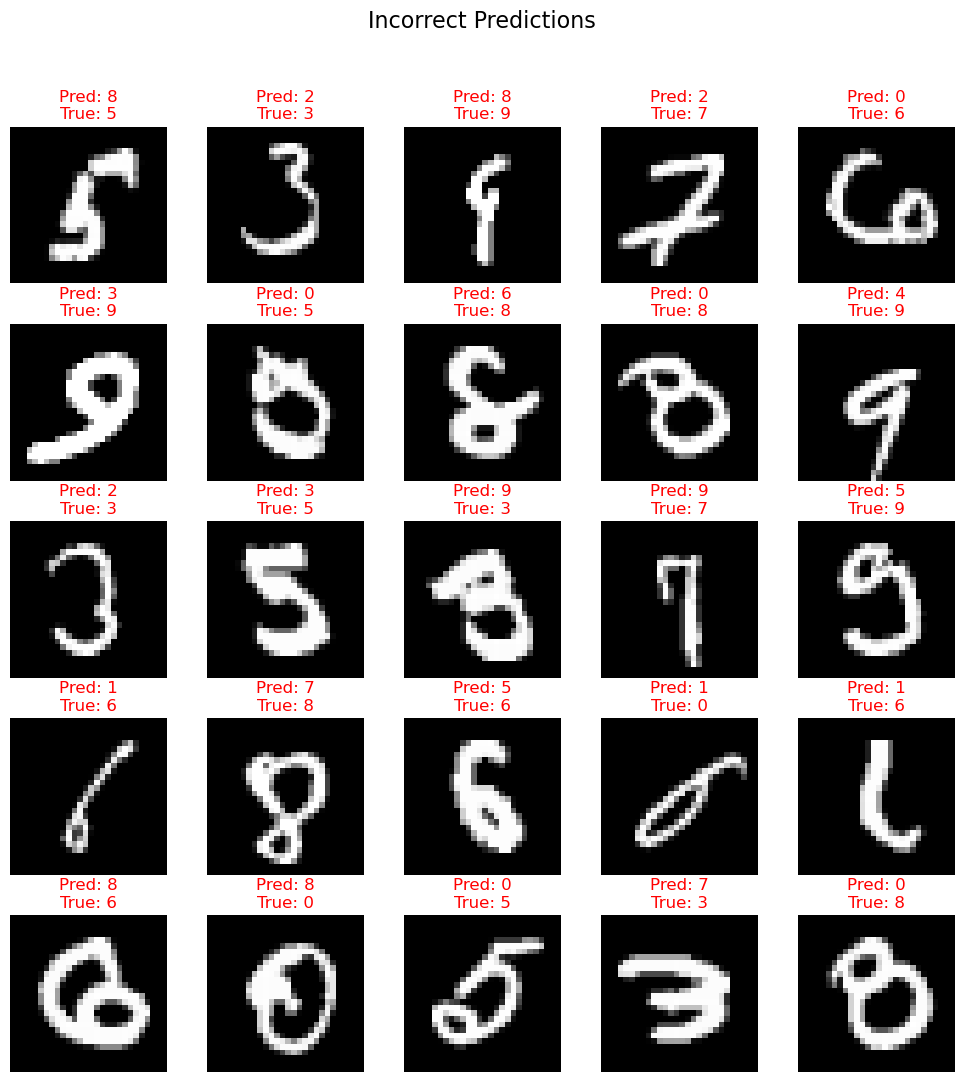

In [22]:
# Ensure all tensors are on the CPU for comparison and plotting
all_predicted_cpu = all_predicted.cpu()
all_labels_cpu = all_labels.cpu()

# Find the indices of all the images that were predicted incorrectly
incorrect_indices = (all_predicted_cpu != all_labels_cpu).nonzero().squeeze()

# Print the number of incorrect predictions
num_incorrect = len(incorrect_indices)
print(f"Number of incorrect predictions on the test set: {num_incorrect}")
print(f"This is an error rate of {num_incorrect/len(all_labels_cpu)*100}\n")

# Let's see 25 incorrect samples
num_to_display = min(num_incorrect, 25)

# Randomly select indices from the incorrect_indices tensor
random_indices = incorrect_indices[torch.randperm(num_incorrect)[:num_to_display]]

# Create a figure to display the incorrect predictions
rows = int(np.ceil(num_to_display / 5))
fig, axes = plt.subplots(rows, 5, figsize=(10, 2 * rows + 1))
fig.suptitle('Incorrect Predictions', fontsize=16)


axes = axes.flatten()

for i, idx in enumerate(random_indices):
    ax = axes[i]

    # Get the image, its true label, and the model's prediction from the original test_dataset
    image, true_label = test_dataset[idx]
    predicted_label = all_predicted_cpu[idx].item()

    # Reshape the image and display
    ax.imshow(image.squeeze(), cmap='gray') # Use squeeze() to remove the channel dimension

    # Set the title with the predicted and true labels
    ax.set_title(f"Pred: {predicted_label}\nTrue: {true_label}", color='red')

    ax.axis('off')

# Hide any unused subplots
for i in range(num_to_display, len(axes)):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Some things to think about

- Our accuracy is good, but can we do better? Try changing the learning_rate, batch_size, or the number of num_epochs. What do you observe?
*   What are some alternative activation functions and what is the importance of them?
- Try to implement one-hot encoding for these labels
*   See more details about Adam optimizer and is it better than naive SGD and if yes then how?
- What happens if you remove a hidden layer? Or add a third one? How does this affect the training time and the final accuracy?
- Find out other ways of preventing overfitting and different regularisation techniques (dropout, residual layers and so on)
- Learn how to save and load a trained model. [source](https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html)
- How might you deploy this model for production use? Try creating an interface where user can draw or upload an image of handwritten image and the model can infer on that sample and return correct label.

**Important:**

MNIST dataset is a very simple dataset and can mask many challenges that one can face during computer vision tasks.
One important point is if our simple network can give us this good accuracy then why do we need CNNs?

I want you to think what type of data-processing we are doing and how it might affect our data. (Hint: See what is invariance and inductive bias)


# Sources and Further Reading



*    [3blue1brown playlist on Neural Networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
*   [Blog](https://www.3blue1brown.com/lessons/neural-networks) where you can try out the network by drawing the digits yourself
- Read about NN training and how automatic differentiation with autograd works in [Pytorch's official documentation](https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

Some amazing video resources for deeper understanding:
- [Welch Labs](https://youtu.be/l-9ALe3U-Fg?si=EYzLp8AVfO6y8E1J) have some amazing videos on inner working of different architectures starting from ground up
- [The Independant Code](https://www.youtube.com/@independentcode/videos) Similar high quality videos on understanding the origin and foundational ideas for some bsaic concepts
- [This](https://youtu.be/FBpPjjhJGhk?si=cWscVYOIMh6h4JMW) video goes in-depth about why non-linearities(activation functions) are required during learning 